# CNN Waste Classification

## Introduction

Purpose, goal, context, blah blah blah

## Data Pre-Processing

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
#!pip install torch -- uncomment first time you run
import seaborn as sns
#!pip install torch -- uncomment first time you run
import torch
#!pip install torchvision -- uncomment first time you run
import torchvision
from torchvision import datasets, transforms, models
from torch import nn, optim
from sklearn.metrics import confusion_matrix, classification_report
from torchvision.datasets import ImageFolder

In [3]:
# Define set of transformations- convert image to PyTorch tensor, scale pixels from 0-255 to 0.0 - 1.0, normalizes pixels to -1.0 - 1.0
# Output is a (3, 256, 256) array --> Color channels 0.0 - 1.0 and the dimensions 256x256
transform_scratch = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

In [4]:
# Load in the dataset and apply the transform
from torchvision.datasets import ImageFolder

full_dataset = ImageFolder(root="images/", transform=transform_scratch)
print(f"Total images: {len(full_dataset)}") # Print number of images
print(f"Class labels: {full_dataset.classes}") # Print all of the class labels

Total images: 15000
Class labels: ['aerosol_cans', 'aluminum_food_cans', 'aluminum_soda_cans', 'cardboard_boxes', 'cardboard_packaging', 'clothing', 'coffee_grounds', 'disposable_plastic_cutlery', 'eggshells', 'food_waste', 'glass_beverage_bottles', 'glass_cosmetic_containers', 'glass_food_jars', 'magazines', 'newspaper', 'office_paper', 'paper_cups', 'plastic_cup_lids', 'plastic_detergent_bottles', 'plastic_food_containers', 'plastic_shopping_bags', 'plastic_soda_bottles', 'plastic_straws', 'plastic_trash_bags', 'plastic_water_bottles', 'shoes', 'steel_food_cans', 'styrofoam_cups', 'styrofoam_food_containers', 'tea_bags']


## Define Data Splits

-- **NOTES** --

Here we can mess around with different training splits such as 
- Random split
- Evenly divide each sub-category (Stratified)
- Evenly divide each sub-category AND default/real world images (Double Stratified)
- Train more on default images, test more on real world (Studio Train)

All of these are implemented below. Maybe we start with either random or double stratified but can test out all going forward.

In [5]:
from torch.utils.data import random_split
from sklearn.model_selection import StratifiedShuffleSplit
from torch.utils.data import Subset
from sklearn.model_selection import train_test_split

import numpy as np

# Set the split sizes
dataset_size = len(full_dataset)
train_size = int(0.7 * dataset_size) # TRAIN proportion = 0.7
val_size = int(0.15 * dataset_size) # VALIDATION proportion = 0.15
test_size = dataset_size - train_size - val_size  # TEST proportion = 0.15

##### RANDOMLY split the dataset #####
random_train_dataset, random_val_dataset, random_test_dataset = random_split(full_dataset, [train_size, val_size, test_size])

print(f"Random Train size: {len(random_train_dataset)}")
print(f"Random Validation size: {len(random_val_dataset)}")
print(f"Random Test size: {len(random_test_dataset)}\n")

##### STRATIFIED SPLIT (Evenly distribute each category between the train, val, test proportions) #####
## Get all targets from the dataset
targets = np.array(full_dataset.targets)

# 1st split: Separate 70% training data and 30% temp (which will become val + test)
splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=42)
train_idx, temp_idx = next(splitter.split(np.zeros(len(targets)), targets))

# Use class labels from the temp split to do a second stratified split (val and test)
temp_targets = targets[temp_idx]

# 2nd split: Split the 30% temp into 15% val and 15% test
splitter2 = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=42)
val_idx, test_idx = next(splitter2.split(np.zeros(len(temp_idx)), temp_targets))

# Since val/test indices refer to the temp set, map them back to the full dataset
val_idx = temp_idx[val_idx]
test_idx = temp_idx[test_idx]

# Create PyTorch Subset objects for each split, using the final indices
strat_train_dataset = Subset(full_dataset, train_idx)
strat_val_dataset = Subset(full_dataset, val_idx)
strat_test_dataset = Subset(full_dataset, test_idx)

# Print sizes again
print(f"Stratified Train size: {len(strat_train_dataset)}")
print(f"Stratified Validation size: {len(strat_val_dataset)}")
print(f"Stratified Test size: {len(strat_test_dataset)}\n")

##### DOUBLE STRATIFIED SPLIT (Evenly distribute each category and real world vs default between train/val/test) #####
# Step 1: Create a list of full file paths for all images
all_paths = [full_dataset.samples[i][0] for i in range(len(full_dataset))]

# Step 2: Create a combined stratification label for each image: e.g., "plastic_water_bottles__default"
combined_labels = []
for path in all_paths:
    # Example path: images/plastic_water_bottles/default/image1.png
    parts = path.split(os.sep)
    category = parts[-3]  # e.g., plastic_water_bottles
    subtype = parts[-2]   # e.g., default or real_world
    combined_label = f"{category}__{subtype}"
    combined_labels.append(combined_label)

combined_labels = np.array(combined_labels)

# Step 3: First split: 70% train, 30% temp (val + test)
split1 = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=42)
train_idx, temp_idx = next(split1.split(np.zeros(len(combined_labels)), combined_labels))

# Step 4: Second split: split temp into 50% val, 50% test (i.e., 15% each overall)
temp_labels = combined_labels[temp_idx]
split2 = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=42)
val_idx_rel, test_idx_rel = next(split2.split(np.zeros(len(temp_labels)), temp_labels))

# Map relative val/test indices back to full dataset indices
val_idx = temp_idx[val_idx_rel]
test_idx = temp_idx[test_idx_rel]

# Step 5: Create PyTorch Subsets
double_strat_train_dataset = Subset(full_dataset, train_idx)
double_strat_val_dataset = Subset(full_dataset, val_idx)
double_strat_test_dataset = Subset(full_dataset, test_idx)

# Optional sanity check
print(f"Double Stratified Train size: {len(double_strat_train_dataset)}")
print(f"Double Stratified Validation size: {len(double_strat_val_dataset)}")
print(f"Double Stratified Test size: {len(double_strat_test_dataset)}\n")

##### DEFAULT v REAL WORLD TRAIN SPLIT (All default goes to train, real_world fills in remaining train, then val & test) #####
# Map: class index → class name (e.g., 0 → 'plastic_water_bottles')
# Map class index → class name (e.g., 0 → 'plastic_water_bottles')
idx_to_class = {v: k for k, v in full_dataset.class_to_idx.items()}

# Split default and real_world
default_indices = []
realworld_indices = []

for i, (path, class_idx) in enumerate(full_dataset.samples):
    subtype = path.split(os.sep)[-2]  # 'default' or 'real_world'
    if subtype == "default":
        default_indices.append(i)
    elif subtype == "real_world":
        realworld_indices.append(i)

# Calculate dataset sizes
total_size = len(full_dataset)
target_train_size = int(0.7 * total_size)
target_val_size = int(0.15 * total_size)
target_test_size = total_size - target_train_size - target_val_size

# Use all default images in training set
train_idx = set(default_indices)

# How many more real_world images needed for train?
remaining_needed = target_train_size - len(train_idx)

# Sanity check
if remaining_needed < 0:
    raise ValueError("Too many default images to satisfy 70% train split!")

# Convert to array
realworld_indices = np.array(realworld_indices)

# First: get required real_world images for training
rw_train_idx, rw_temp_idx = train_test_split(
    realworld_indices,
    train_size=remaining_needed,
    random_state=42,
    shuffle=True
)

# Second: split the rest equally into val and test
rw_val_idx, rw_test_idx = train_test_split(
    rw_temp_idx,
    test_size=0.5,
    random_state=42,
    shuffle=True
)

# Final index sets
train_idx.update(rw_train_idx)
val_idx = set(rw_val_idx)
test_idx = set(rw_test_idx)

# Create subsets
drw_train_dataset = Subset(full_dataset, sorted(train_idx))
drw_val_dataset = Subset(full_dataset, sorted(val_idx))
drw_test_dataset = Subset(full_dataset, sorted(test_idx))

# Print final sizes
print(f"DRW Train size: {len(drw_train_dataset)}")
print(f"DRW Validation size: {len(drw_val_dataset)}")
print(f"DRW Test size: {len(drw_test_dataset)}")

Random Train size: 10500
Random Validation size: 2250
Random Test size: 2250

Stratified Train size: 10500
Stratified Validation size: 2250
Stratified Test size: 2250

Double Stratified Train size: 10500
Double Stratified Validation size: 2250
Double Stratified Test size: 2250

DRW Train size: 10500
DRW Validation size: 2250
DRW Test size: 2250


### Implement Data Loader

In [7]:
from torch.utils.data import DataLoader

# Use data loader to improve efficiency of loading data during training
batch_size = 32  # Can be adjusted

# shuffle = True : Ensures all images from a category aren't trained on consecutively
train_loader = DataLoader(random_train_dataset, batch_size=batch_size, shuffle=True) 
val_loader = DataLoader(random_val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(random_test_dataset, batch_size=batch_size, shuffle=False)


## Build CNN

In [8]:
import torch.nn as nn
import torch.nn.functional as F

In [10]:
#!pip install tensorflow matplotlib scikit-learn

In [12]:
from torch.utils.data import DataLoader

batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


In [7]:
import torch.nn as nn
import torch.nn.functional as F

class WasteClassifierCNN(nn.Module):
    def __init__(self, num_classes):
        super(WasteClassifierCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)

        # Placeholder for fc1 — we'll initialize it after knowing the flatten size
        self._flattened_size = None
        self.fc1 = None
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))

        x = torch.flatten(x, 1)

        # Initialize fc1 if we haven't yet
        if self.fc1 is None:
            self._flattened_size = x.shape[1]
            self.fc1 = nn.Linear(self._flattened_size, 128).to(x.device)

        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

In [8]:
num_classes = len(full_dataset.classes)
model = WasteClassifierCNN(num_classes)

In [9]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [12]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

num_epochs = 7

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)
    
    train_accuracy = 100 * correct / total
    print(f"Epoch {epoch+1}, Loss: {running_loss:.3f}, Train Accuracy: {train_accuracy:.2f}%")

Epoch 1, Loss: 1065.459, Train Accuracy: 20.75%
Epoch 2, Loss: 1026.542, Train Accuracy: 23.36%
Epoch 3, Loss: 1002.822, Train Accuracy: 24.92%
Epoch 4, Loss: 979.822, Train Accuracy: 26.45%
Epoch 5, Loss: 963.695, Train Accuracy: 27.52%
Epoch 6, Loss: 945.578, Train Accuracy: 28.23%
Epoch 7, Loss: 928.535, Train Accuracy: 30.22%


In [13]:
from sklearn.metrics import classification_report, confusion_matrix

all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.numpy())

print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=full_dataset.classes))

print("Confusion Matrix:")
print(confusion_matrix(all_labels, all_preds))

Classification Report:
                            precision    recall  f1-score   support

              aerosol_cans       0.20      0.09      0.12       110
        aluminum_food_cans       0.26      0.16      0.19       116
        aluminum_soda_cans       0.29      0.21      0.25       103
           cardboard_boxes       0.38      0.56      0.45       113
       cardboard_packaging       0.33      0.18      0.23       106
                  clothing       0.35      0.30      0.32       105
            coffee_grounds       0.52      0.80      0.63        85
disposable_plastic_cutlery       0.34      0.17      0.23        94
                 eggshells       0.29      0.23      0.26       100
                food_waste       0.33      0.62      0.43        99
    glass_beverage_bottles       0.34      0.43      0.38       102
 glass_cosmetic_containers       0.24      0.33      0.28        99
           glass_food_jars       0.38      0.37      0.38       100
                 magazin

In [13]:
# ----------------------
# IMPORTS
# ----------------------
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from tqdm import tqdm

# ----------------------
# DEVICE SETUP
# ----------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# ----------------------
# MODEL DEFINITION
# ----------------------
class WasteClassifierCNN(nn.Module):
    def __init__(self, num_classes):
        super(WasteClassifierCNN, self).__init__()
        # Convolutional layers with increasing filters
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)     # Output: (B, 32, 128, 128)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)    # Output: (B, 64, 64, 64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)   # Output: (B, 128, 32, 32)

        self.pool = nn.MaxPool2d(2, 2)  # Halves spatial dimensions each time

        # Flattened feature map size: 128 channels × 32 × 32
        self.flattened_size = 128 * 32 * 32
        self.fc1 = nn.Linear(self.flattened_size, 256)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # (B, 32, 128, 128)
        x = self.pool(F.relu(self.conv2(x)))  # (B, 64, 64, 64)
        x = self.pool(F.relu(self.conv3(x)))  # (B, 128, 32, 32)
        x = x.view(x.size(0), -1)             # Flatten
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# ----------------------
# MODEL INITIALIZATION
# ----------------------
num_classes = len(full_dataset.classes)  # Detect based on your dataset
model = WasteClassifierCNN(num_classes=num_classes).to(device)

# ----------------------
# LOSS FUNCTION & OPTIMIZER
# ----------------------
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# ----------------------
# TRAINING LOOP (Keras-style progress output)
# ----------------------
num_epochs = 5  # Adjust as needed

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    print(f"\nEpoch {epoch+1}/{num_epochs}")  # Keras-style clean epoch header

    # Progress bar on batches
    loop = tqdm(train_loader, total=len(train_loader), leave=True, ncols=100)

    for images, labels in loop:
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimizer step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Running loss and accuracy
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Update progress bar
        loop.set_postfix({
            "acc": f"{(correct / total):.4f}",
            "loss": f"{running_loss / (loop.n + 1):.4f}"
        })


Using device: cpu

Epoch 1/5


100%|████████████████████████████████████| 375/375 [05:19<00:00,  1.17it/s, acc=0.2524, loss=2.6979]



Epoch 2/5


100%|████████████████████████████████████| 375/375 [05:20<00:00,  1.17it/s, acc=0.5252, loss=1.6999]



Epoch 3/5


100%|████████████████████████████████████| 375/375 [05:24<00:00,  1.15it/s, acc=0.7218, loss=0.9627]



Epoch 4/5


100%|████████████████████████████████████| 375/375 [05:22<00:00,  1.16it/s, acc=0.8630, loss=0.4595]



Epoch 5/5


100%|████████████████████████████████████| 375/375 [05:27<00:00,  1.15it/s, acc=0.9276, loss=0.2545]


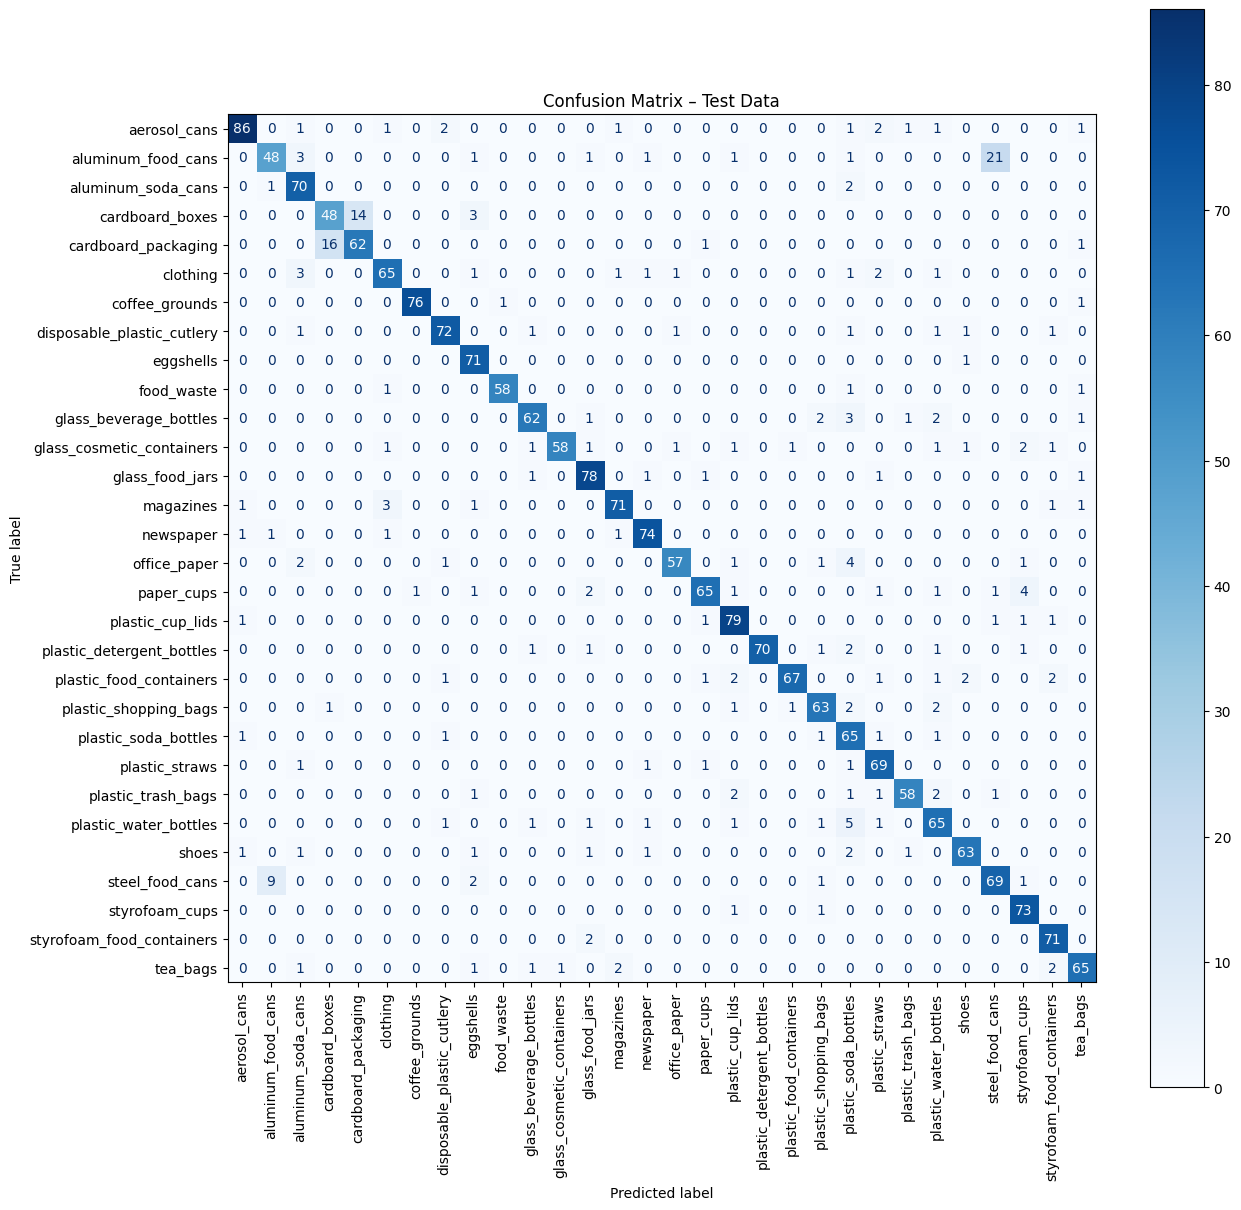

In [15]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=full_dataset.classes)

fig, ax = plt.subplots(figsize=(14, 14))
disp.plot(ax=ax, xticks_rotation=90, cmap="Blues")
plt.title("Confusion Matrix – Test Data")
plt.show()


In [16]:
class_correct = [0] * num_classes
class_total = [0] * num_classes

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        for label, prediction in zip(labels, predicted):
            class_total[label] += 1
            if label == prediction:
                class_correct[label] += 1

print("\n🔍 Per-Class Accuracy Breakdown:\n" + "-"*40)
for i, class_name in enumerate(full_dataset.classes):
    acc = 100 * class_correct[i] / class_total[i] if class_total[i] > 0 else 0.0
    print(f"{class_name:30s} — Accuracy: {acc:.2f}%")



🔍 Per-Class Accuracy Breakdown:
----------------------------------------
aerosol_cans                   — Accuracy: 88.66%
aluminum_food_cans             — Accuracy: 62.34%
aluminum_soda_cans             — Accuracy: 95.89%
cardboard_boxes                — Accuracy: 73.85%
cardboard_packaging            — Accuracy: 77.50%
clothing                       — Accuracy: 85.53%
coffee_grounds                 — Accuracy: 97.44%
disposable_plastic_cutlery     — Accuracy: 91.14%
eggshells                      — Accuracy: 98.61%
food_waste                     — Accuracy: 95.08%
glass_beverage_bottles         — Accuracy: 86.11%
glass_cosmetic_containers      — Accuracy: 84.06%
glass_food_jars                — Accuracy: 93.98%
magazines                      — Accuracy: 91.03%
newspaper                      — Accuracy: 94.87%
office_paper                   — Accuracy: 85.07%
paper_cups                     — Accuracy: 84.42%
plastic_cup_lids               — Accuracy: 94.05%
plastic_detergent_bottles 

In [17]:
correct = sum(class_correct)
total = sum(class_total)
overall_acc = 100 * correct / total
print(f"\n✅ Overall Test Accuracy: {overall_acc:.2f}%")


✅ Overall Test Accuracy: 88.80%


In [6]:
##ANTI-OVERFITTING

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Model with Dropout
class WasteClassifierCNN(nn.Module):
    def __init__(self, num_classes):
        super(WasteClassifierCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)

        self.flattened_size = 128 * 32 * 32
        self.fc1 = nn.Linear(self.flattened_size, 256)
        self.dropout = nn.Dropout(p=0.3) # Randomly zeroes 50% of neurons during training
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x) # Applies dropout during training only
        x = self.fc2(x)
        return x

# Initialize model
num_classes = len(full_dataset.classes)
model = WasteClassifierCNN(num_classes).to(device)

# Loss & Optimizer with L2 regularization (weight_decay)
criterion = nn.CrossEntropyLoss()

# L2 regularization is implemented by setting weight_decay
# Helps penalize large weights to reduce overfitting (larger means greater penalty for higher weights)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

# Loaders
train_loader = random_train_loader
val_loader = random_val_loader

# Training with Early Stopping
num_epochs = 10
patience = 2
best_val_loss = float('inf')
patience_counter = 0

history = {"loss": [], "val_loss": []}

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    loop = tqdm(train_loader, total=len(train_loader), leave=False)

    for images, labels in loop:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        loop.set_postfix({
            "acc": f"{(correct / total):.4f}",
            "loss": f"{running_loss / (loop.n + 1):.4f}"
        })

    # Record training loss
    train_loss = running_loss / len(train_loader)
    history["loss"].append(train_loss)

    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    val_loss /= len(val_loader)
    history["val_loss"].append(val_loss)

    print(f"Epoch {epoch+1} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss # Update best loss
        patience_counter = 0 # Reset counter if improvement
        torch.save(model.state_dict(), "best_model.pt") # Save model checkpoint
    else: 
        patience_counter += 1 # No improvement → increase patience counter
        if patience_counter >= patience: # Stop training if patience exhausted
            print(f"Early stopping triggered after {epoch+1} epochs.")
            break


Using device: cpu


NameError: name 'random_train_loader' is not defined